In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("../meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['PRECIPITATION']
df = df[required_cols]
df = df.resample('3h').mean()
df

,PRECIPITATION
DATE,
2018-06-17 12:00:00,0.200000
2018-06-17 15:00:00,0.133333
2018-06-17 18:00:00,0.000000
2018-06-17 21:00:00,0.000000
2018-06-18 00:00:00,0.000000
...,...
2024-06-15 00:00:00,0.000000
2024-06-15 03:00:00,0.000000
2024-06-15 06:00:00,0.000000


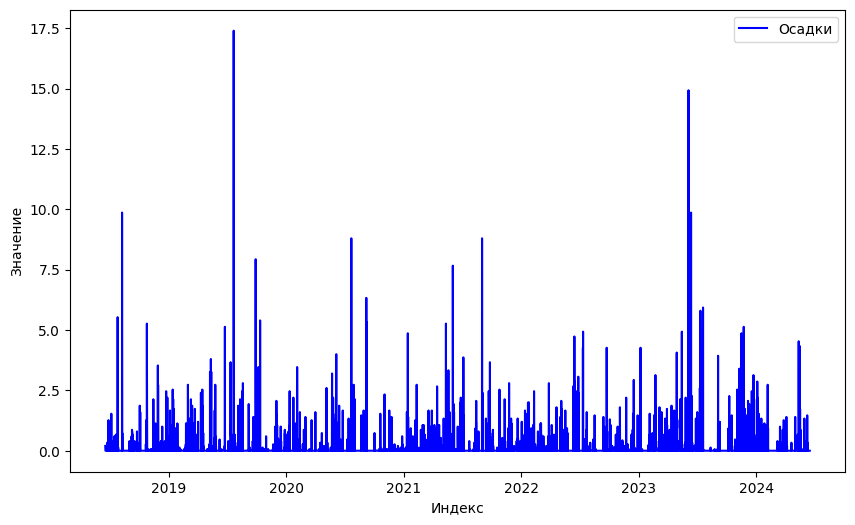

In [6]:
temp = df['PRECIPITATION']

plt.figure(figsize=(10, 6))
plt.plot(df['PRECIPITATION'], label='Осадки', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [7]:
# [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]   [11]
# [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11]]  [12]
# [[3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [13]
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

# Размеры выборок
n = len(df)
train_size = int(n * 0.75)
val_size = int(n * 0.125)
test_size = n - train_size - val_size

X_train1, y_train1 = X1[:train_size], y1[:train_size]
X_val1, y_val1 = X1[train_size:train_size + val_size], y1[train_size:train_size + val_size]
X_test1, y_test1 = X1[train_size + val_size:], y1[train_size + val_size:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((13140, 24, 1), (13140,), (2190, 24, 1), (2190,), (2167, 24, 1), (2167,))

In [8]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='relu'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,009 (246.13 KB)

 Trainable params: 63,009 (246.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Настройки обратного вызова и компиляции модели
model_save_path = 'model2/model2-PRECIPITATION.keras'  
cp2 = ModelCheckpoint(model_save_path, save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [10]:
# Обучение модели
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - loss: 0.1554 - root_mean_squared_error: 0.3918 - val_loss: 0.2940 - val_root_mean_squared_error: 0.5422
Epoch 2/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0997 - root_mean_squared_error: 0.3128 - val_loss: 0.2920 - val_root_mean_squared_error: 0.5404
Epoch 3/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 0.1542 - root_mean_squared_error: 0.3915 - val_loss: 0.2925 - val_root_mean_squared_error: 0.5409
Epoch 4/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.2153 - root_mean_squared_error: 0.4577 - val_loss: 0.2910 - val_root_mean_squared_error: 0.5395
Epoch 5/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 0.1293 - root_mean_squared_error: 0.3582 - val_loss: 0.2904 - val_root_mean_squared_error: 0.5389
Epoch 6/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 0.1433 - root_mean_squared_error: 0.3759 - val_loss: 0.2895 - val_root_mean_squared_error: 0.5381
Epoch 7/50
411/411 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# Сохранение всей модели на диск
model_save_path = 'model2/model2-PRECIPITATION.keras'
model2.save(model_save_path)
print(f"Модель сохранена в {model_save_path}")

Модель сохранена в model2/model2-PRECIPITATION.keras


In [12]:
from keras.models import load_model
model2 = load_model('model2/model2-PRECIPITATION.keras')

In [13]:
# Прогнозирование на тестовых данных
y_pred = model2.predict(X_test1)

# Вывод предсказаний
print(y_pred)

68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 181ms/step
[[0.0167442]
 [0.0167442]
 [0.0167442]
 ...
 [0.0167442]
 [0.0167442]
 [0.0167442]]


In [17]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=24):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='3h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append(prediction[0, 0])
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = temp.values[-WINDOW_SIZE:]
last_known_dates = temp.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 56
future_dates, predictions = predict_future(model2, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


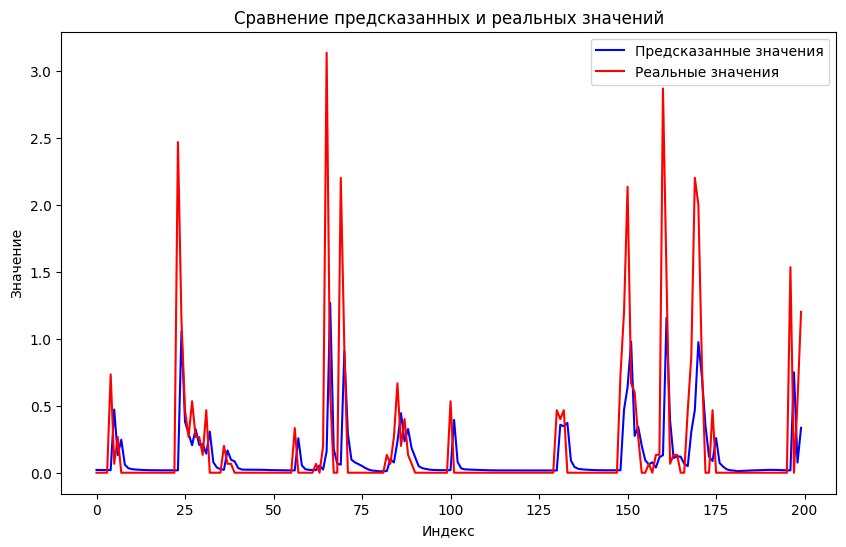

In [18]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [19]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 0.09821734445281596
Средняя квадратичная ошибка (MSE): 0.10838869792634646
Корень из среднеквадратичной ошибки (RMSE): 0.329224388413657
Коэффициент детерминации (R^2): 0.21031115758739516
